# <center>_Toxic Comment Detection_</center>

## _Loading Data_

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("labeled.csv", sep=",")
df['toxic'] = df['toxic'].apply(int)

___

## _EDA_

In [3]:
df.shape

(14412, 2)

In [4]:
df['toxic'].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [5]:
df.query('toxic == 1')['comment']

0                     Верблюдов-то за что? Дебилы, бл...\n
1        Хохлы, это отдушина затюканого россиянина, мол...
2                                Собаке - собачья смерть\n
3        Страницу обнови, дебил. Это тоже не оскорблени...
4        тебя не убедил 6-страничный пдф в том, что Скр...
                               ...                        
14404    ЖЕНЩИНА это ВЕНЕЦ ТВОРЕНИЯ, помните это ваньки...
14405    Сейчас все авиакомпании мира вместе со специал...
14407    Вонючий совковый скот прибежал и ноет. А вот и...
14408    А кого любить? Гоблина тупорылого что-ли? Или ...
14410    КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...
Name: comment, Length: 4826, dtype: object

In [6]:
df.query('toxic == 0')['comment']

6        В шапке были ссылки на инфу по текущему фильму...
12       Почитайте посты у этого автора,может найдете ч...
17       Про графику было обидно) я так то проходил все...
28       https: pp.userapi.com c848520 v848520411 11627...
35       Возьмём как пример Россию, западноевропейские ...
                               ...                        
14392    ТАСС, 21 марта. Премьер-министр Новой Зеландии...
14399    65 А чего так мало? Вот у гражданина был рейти...
14406    Потому что запад прошел эту хуйню еще пару сот...
14409    Посмотрел Утомленных солнцем 2. И оказалось, ч...
14411    До сих пор пересматриваю его видео. Орамбо кст...
Name: comment, Length: 9586, dtype: object

In [7]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
# nltk.download('punkt')
# nltk.download('stopwords')

stemmer = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')

def tokenize_sentence(sentence: str, remove_stop_words: bool=True):
    """Преобразует предложения в токены.
    По шагам:
    1) Токенизация - разбиение текста на отдельные слова и знаки пунктуации
    2) Удаляем знаки пунктуации
    3) Удаляем стоп-слова (часто используемые, не несущие смысловой нагрузки)
    4) Стемминг (stem - корень) - удаление окончаний и приведение к нижнему регистру
    """
    tokens = word_tokenize(sentence, language='russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [stemmer.stem(i) for i in tokens]
    return tokens

In [8]:
example = df.loc[1]['comment']
example

'Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.\n'

In [9]:
tokenize_sentence(example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [11]:
from sklearn.model_selection import train_test_split

features, labels = df['comment'], df['toxic']
features = vectorizer.fit_transform(features)
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                   labels, 
                                                   test_size=0.2, 
                                                   random_state=0)

C:\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


___

## _Testing Different Models_

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [158]:
def model_testing(clf, x_train, y_train, x_test, y_test):
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    prec, rc, roc_auc = precision_score(y_test, y_pred), recall_score(y_test, y_pred), roc_auc_score(y_test, y_pred)
    print(f'Precision: {prec}\n   Recall: {rc}\n  ROC-AUC: {roc_auc}')

In [140]:
model_testing(KNeighborsClassifier(), x_train, y_train, x_test, y_test)

Precision: 0.8192182410423453
   Recall: 0.5212435233160622
  ROC-AUC: 0.7316853695829529


In [135]:
model_testing(LogisticRegression(), x_train, y_train, x_test, y_test)

Precision: 0.9160063391442155
   Recall: 0.5989637305699482
  ROC-AUC: 0.7856653897896665


In [136]:
model_testing(DecisionTreeClassifier(), x_train, y_train, x_test, y_test)

Precision: 0.6968215158924206
   Recall: 0.5906735751295337
  ROC-AUC: 0.7306861097754028


In [159]:
model_testing(SGDClassifier(loss='log_loss'), x_train, y_train, x_test, y_test)

Precision: 0.9174757281553398
   Recall: 0.5875647668393782
  ROC-AUC: 0.7804872843581667


In [132]:
model_testing(RandomForestClassifier(n_estimators=50), x_train, y_train, x_test, y_test)

Precision: 0.8993174061433447
   Recall: 0.5461139896373057
  ROC-AUC: 0.7576763900219897


___

## _kNN_

In [19]:
from sklearn.model_selection import GridSearchCV

knn_grid = GridSearchCV(KNeighborsClassifier(), 
                        param_grid={'n_neighbors': range(10, 21)}, 
                        cv=3)
knn_grid.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(10, 21)})

In [20]:
print(f'best params: {knn_grid.best_params_}')
print(f'best score: {knn_grid.best_score_}')

knn.set_params(**knn_grid.best_params_).fit(x_train, y_train)    #эквивалентно knn_grid.fit(x_train y_train)

y_pred_knn_best = knn.predict(x_test)                            #эквивалентно knn_grid.predict(x_test)
knn_precision_best = precision_score(y_test, y_pred_knn_best)
knn_recall_best = recall_score(y_test, y_pred_knn_best)
knn_roc_auc_best = roc_auc_score(y_test, y_pred_knn_best)
print(f'AFTER Cross-validation')
print(f'Precision: {knn_precision_best}\nRecall: {knn_recall_best}\nROC-AUC: {knn_roc_auc_best}')
# print('-------------------------------------------------')
# print(classification_report(y_test, y_pred_knn_best))

best params: {'n_neighbors': 11}
best score: 0.8240090207303322
AFTER Cross-validation
Precision: 0.864696734059098
Recall: 0.5761658031088083
ROC-AUC: 0.7654030266847484


___

## _Logistic Regression_

In [21]:
from sklearn.linear_model import LogisticRegressionCV

cs = np.logspace(-1, 2, 100)
log_reg_cv = LogisticRegressionCV(Cs=cs, 
                                  cv=3, 
                                  verbose=0, 
                                  max_iter=300,
                                  random_state=0)
log_reg_cv.fit(x_train, y_train)

LogisticRegressionCV(Cs=array([  0.1       ,   0.10722672,   0.1149757 ,   0.12328467,
         0.13219411,   0.14174742,   0.15199111,   0.16297508,
         0.17475284,   0.18738174,   0.2009233 ,   0.21544347,
         0.23101297,   0.24770764,   0.26560878,   0.28480359,
         0.30538555,   0.32745492,   0.35111917,   0.37649358,
         0.40370173,   0.43287613,   0.46415888,   0.49770236,
         0.53366992,   0.57223677,   0.61359073,   0.65793322,
         0.70548023,   0.7564633...
        15.19911083,  16.29750835,  17.475284  ,  18.73817423,
        20.09233003,  21.5443469 ,  23.101297  ,  24.77076356,
        26.56087783,  28.48035868,  30.53855509,  32.74549163,
        35.11191734,  37.64935807,  40.37017259,  43.28761281,
        46.41588834,  49.77023564,  53.36699231,  57.22367659,
        61.35907273,  65.79332247,  70.54802311,  75.64633276,
        81.11308308,  86.97490026,  93.26033469, 100.        ]),
                     cv=3, max_iter=300, random_state=0)

In [22]:
print(f'best C: {log_reg_cv.C_}')

y_pred_lr_best = log_reg_cv.predict(x_test)

lr_precision_best = precision_score(y_test, y_pred_lr_best)
lr_recall_best = recall_score(y_test, y_pred_lr_best)
lr_roc_auc_best = roc_auc_score(y_test, y_pred_lr_best)
print(f'AFTER Cross-validation')
print(f'Precision: {lr_precision_best}\nRecall: {lr_recall_best}\nROC-AUC: {lr_roc_auc_best}')
# print('-------------------------------------------------')
# print(classification_report(y_test, y_pred_lr_best))

best C: [5.33669923]
AFTER Cross-validation
Precision: 0.8832684824902723
Recall: 0.705699481865285
ROC-AUC: 0.8293878014123088


In [23]:
from sklearn.metrics import precision_recall_curve

pr, rc, ths = precision_recall_curve(y_true=y_test, 
                                    probas_pred=log_reg_cv.predict_proba(x_test)[:,1])

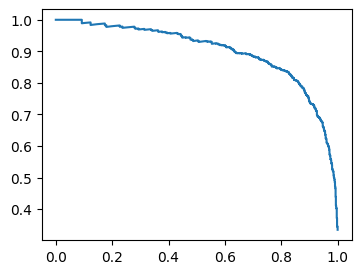

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(4, 3))
plt.plot(rc, pr)

In [25]:
pr_index = np.where(pr > 0.95)[0][0]
threshold = ths[pr_index].round(4)
probas = (log_reg_cv.predict_proba(x_test)[:,1] > threshold)
print(f'Precision: {precision_score(y_test, probas)}')
print(f'   Recall: {recall_score(y_test, probas)}')

Precision: 0.9512195121951219
   Recall: 0.44455958549222796


In [26]:
threshold

0.7515

___

## _Gradient Descent_

___

## _Decision Tree_

___

## _Random Forest_

___